# 03 – Monthly Usage Analytics (Daily → Monthly Aggregation)

## Purpose

This notebook builds the **monthly analytics layer** of the project by aggregating daily demand metrics into monthly KPIs for each NEM region.

Using the `daily_usage` table created earlier, we compute per region and month:

- Average daily demand
- Monthly peak and minimum demand
- Total monthly energy (MWh)

## How it fits into the overall methodology

This is **Layer 3 – Monthly Analytics** in the project pipeline:

1. **Layer 1 – Raw 5-minute data** → `dispatch_region_5min`  
2. **Layer 2 – Daily usage** → `daily_usage`  
3. **Layer 3 – Monthly usage & seasonal patterns** → `monthly_usage` (this notebook)  
4. Later layers build on this to create:
   - Seasonal behaviour summaries
   - Region-level KPIs
   - Power BI dashboards

The final output of this notebook is a clean `monthly_usage` table in PostgreSQL.


## STEP 3.1 — Load Environment & Connect to PostgreSQL

### Why we are doing this

All monthly analytics are built on top of the existing **daily_usage** table stored in PostgreSQL.

We first:

- Load database credentials from the `.env` file (no hard-coded passwords)
- Create a SQLAlchemy engine
- Test the connection

This ensures the notebook can reliably read daily data and write back monthly outputs.


In [1]:
import os
import pandas as pd
from sqlalchemy import create_engine, text
from dotenv import load_dotenv

# -------- 1. LOAD ENV VARIABLES --------
load_dotenv()   # This loads the .env file

DB_USER = os.getenv("DB_USER")
DB_PASSWORD = os.getenv("DB_PASSWORD")
DB_HOST = os.getenv("DB_HOST")
DB_PORT = os.getenv("DB_PORT")
DB_NAME = os.getenv("DB_NAME")

# -------- 2. CREATE ENGINE SAFELY --------
engine = create_engine(
    f"postgresql+psycopg2://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}"
)

# -------- 3. TEST CONNECTION --------
with engine.connect() as conn:
    result = conn.execute(text("SELECT 1;")).fetchall()
    print("✅ DB connection OK:", result)

# -------- 4. LOAD SAMPLE FROM dispatch_region_5min --------
query = """
    SELECT *
    FROM dispatch_region_5min
    ORDER BY settlement_ts
    LIMIT 10;
"""


df_sample = pd.read_sql(query, engine)

print("\n📊 Sample rows:")
print(df_sample)

print("\n📋 Columns:", df_sample.columns.tolist())


✅ DB connection OK: [(1,)]

📊 Sample rows:
        settlement_ts region_id  total_demand
0 2025-01-01 00:05:00      TAS1        989.78
1 2025-01-01 00:05:00      NSW1       7251.07
2 2025-01-01 00:05:00      VIC1       4339.00
3 2025-01-01 00:05:00      QLD1       6444.99
4 2025-01-01 00:05:00       SA1       1379.47
5 2025-01-01 00:05:00      TAS1        989.78
6 2025-01-01 00:05:00      NSW1       7251.07
7 2025-01-01 00:05:00       SA1       1379.47
8 2025-01-01 00:05:00      QLD1       6444.99
9 2025-01-01 00:05:00      VIC1       4339.00

📋 Columns: ['settlement_ts', 'region_id', 'total_demand']


## STEP 3.2 — Load Daily Usage Table (`daily_usage`)

### Why we are doing this

The monthly metrics are derived from the **daily usage table**:

- `daily_usage`
  - `date`
  - `region_id`
  - `avg_5min_demand`
  - `daily_peak`
  - `daily_min`
  - `total_daily_energy_mwh`

We load this table into pandas so that we can:

- Group by month + region
- Compute monthly energy and peaks
- Build seasonal trends

This connects Layer 2 (daily) to Layer 3 (monthly).


In [2]:
df_daily = pd.read_sql("""
    SELECT *
    FROM daily_usage
    ORDER BY date, region_id;
""", engine)

df_daily["date"] = pd.to_datetime(df_daily["date"])
df_daily.head()


,date,region_id,avg_5min_demand,daily_peak,daily_min,total_daily_energy_mwh
0,2025-01-01,NSW1,6774.125714,9434.59,4534.57,486043.5200
1,2025-01-01,QLD1,6039.234634,7808.79,4554.92,433315.0850
2,2025-01-01,SA1,862.286655,1518.36,10.55,61869.0675
3,2025-01-01,TAS1,999.820767,1104.47,920.09,71737.1400
4,2025-01-01,VIC1,3293.134390,4488.60,1400.13,236282.3925


## STEP 3.3 — Aggregate Daily Usage into Monthly Metrics

### Why we are doing this

Working at a daily level is useful for operational analysis, but:

- Seasonal planning
- Long-term trends
- Executive reporting

are usually done at a **monthly** level.

So for each `(month, region_id)` we compute:

- **avg_daily_demand** – average of daily average demand  
- **monthly_peak** – maximum daily peak in that month  
- **monthly_min** – minimum daily minimum in that month  
- **total_monthly_energy_mwh** – total energy consumed in the month  

This step transforms daily operational data into **high-level seasonal KPIs.**


In [3]:
df_daily["month"] = df_daily["date"].dt.to_period("M").astype(str)
df_daily.head()


,date,region_id,avg_5min_demand,daily_peak,daily_min,total_daily_energy_mwh,month
0,2025-01-01,NSW1,6774.125714,9434.59,4534.57,486043.5200,2025-01
1,2025-01-01,QLD1,6039.234634,7808.79,4554.92,433315.0850,2025-01
2,2025-01-01,SA1,862.286655,1518.36,10.55,61869.0675,2025-01
3,2025-01-01,TAS1,999.820767,1104.47,920.09,71737.1400,2025-01
4,2025-01-01,VIC1,3293.134390,4488.60,1400.13,236282.3925,2025-01


In [4]:
monthly_group = df_daily.groupby(["month", "region_id"])

df_monthly = monthly_group.agg(
    avg_daily_demand=("avg_5min_demand", "mean"),
    monthly_peak=("daily_peak", "max"),
    monthly_min=("daily_min", "min"),
    total_monthly_energy_mwh=("total_daily_energy_mwh", "sum")
).reset_index()

df_monthly.head()


,month,region_id,avg_daily_demand,monthly_peak,monthly_min,total_monthly_energy_mwh
0,2025-01,NSW1,7230.060644,12128.62,4188.12,1.613580e+07
1,2025-01,QLD1,6716.615186,11159.32,4351.41,1.498998e+07
2,2025-01,SA1,1252.457724,2485.14,10.55,2.795270e+06
3,2025-01,TAS1,968.286454,1213.70,692.39,2.160965e+06
4,2025-01,VIC1,4408.118995,8733.41,1400.13,9.838098e+06


In [5]:
from sqlalchemy import text

# Optional: clear old table
with engine.connect() as conn:
    conn.execute(text("DROP TABLE IF EXISTS monthly_usage;"))
    print("🧹 Dropped old monthly_usage table (if existed).")

# Write new table
df_monthly.to_sql(
    "monthly_usage",
    engine,
    index=False,
    if_exists="replace"
)

print("✅ monthly_usage table created:", len(df_monthly), "rows")


🧹 Dropped old monthly_usage table (if existed).
✅ monthly_usage table created: 50 rows


## STEP 3.4 — Data Quality Checks on Monthly Metrics

### Why we are doing this

Before using `monthly_usage` for visualisation or dashboards, we need to verify:

- No unexpected missing values in key metrics  
- Ranges make sense (no negative energy, no crazy peaks)  
- Basic statistics align with what we saw in the daily notebook  

This acts as a sanity check on the monthly aggregation.


In [6]:
# Check missing values
df_monthly.isna().sum()


month                       0
region_id                   0
avg_daily_demand            0
monthly_peak                0
monthly_min                 0
total_monthly_energy_mwh    0
dtype: int64

In [7]:
# Basic descriptive stats for numeric fields
df_monthly[[
    "avg_daily_demand",
    "monthly_peak",
    "monthly_min",
    "total_monthly_energy_mwh"
]].describe()


,avg_daily_demand,monthly_peak,monthly_min,total_monthly_energy_mwh
count,50.000000,50.000000,50.000000,5.000000e+01
mean,4251.851725,6525.503400,2130.171400,9.306118e+06
std,2677.039228,4048.013611,1624.185478,5.871728e+06
min,968.286454,1213.700000,-185.490000,1.993500e+06
25%,1254.464256,2200.560000,737.357500,2.740584e+06
50%,4825.838001,8040.945000,2079.885000,1.043322e+07
75%,6544.515883,9463.935000,3482.347500,1.366260e+07
max,8844.295619,13159.460000,5389.370000,1.973789e+07


In [8]:
df_monthly.groupby("region_id")["avg_daily_demand"].mean()


region_id
NSW1    7621.695868
QLD1    6187.103101
SA1     1372.877288
TAS1    1073.342736
VIC1    5004.239634
Name: avg_daily_demand, dtype: float64

## STEP 13.5 — Visualise Monthly Energy Trend (Single Region)


Plotting total monthly energy for a single region helps us see:

- Seasonal peaks and troughs
- Which months place the most stress on the grid
- Whether there are clear winter and summer peaks
- How shoulder months compare

We start with one region (e.g. NSW1) for clarity.


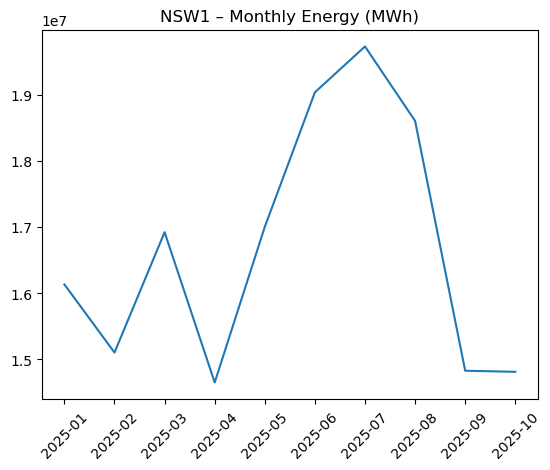

In [9]:
import matplotlib.pyplot as plt

nsw_month = df_monthly[df_monthly["region_id"] == "NSW1"]

plt.plot(nsw_month["month"], nsw_month["total_monthly_energy_mwh"])
plt.xticks(rotation=45)
plt.title("NSW1 – Monthly Energy (MWh)")
plt.show()


### 📝 Interpretation – Single Region Seasonal Pattern

- The curve shows **clear seasonal behaviour**, with higher energy usage during:
  - **Winter months** (heating load)
  - **Summer months** (cooling load)
- The **shoulder months** (e.g., April–May, September–October) show lower, more stable consumption.
- This pattern confirms temperature-driven demand and validates our monthly aggregation.


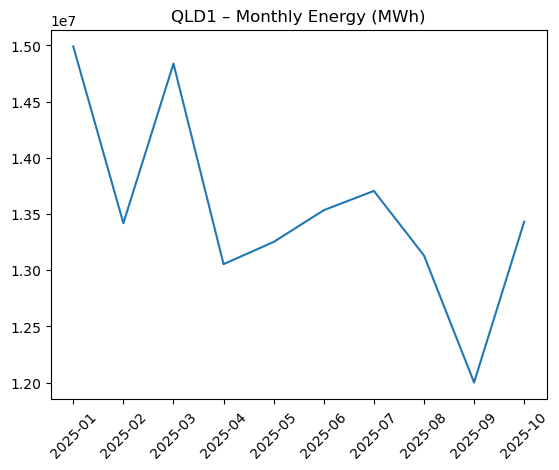

In [10]:
import matplotlib.pyplot as plt

nsw_month = df_monthly[df_monthly["region_id"] == "QLD1"]

plt.plot(nsw_month["month"], nsw_month["total_monthly_energy_mwh"])
plt.xticks(rotation=45)
plt.title("QLD1 – Monthly Energy (MWh)")
plt.show()

In [11]:
from sqlalchemy import text

# Optional: clear old table
with engine.connect() as conn:
    conn.execute(text("DROP TABLE IF EXISTS monthly_usage;"))
    print("🧹 Dropped old monthly_usage table (if existed).")

# Write new table
df_monthly.to_sql(
    "monthly_usage",
    engine,
    index=False,
    if_exists="replace"
)

print("✅ monthly_usage table created:", len(df_monthly), "rows")


🧹 Dropped old monthly_usage table (if existed).
✅ monthly_usage table created: 50 rows


## STEP 13.6 — Compare Seasonal Patterns Across Regions

By plotting all regions together, we can see:

- Which regions consistently consume more energy
- Whether peaks occur in different months for different regions
- How climate and population differences shape demand


This is extremely useful for explaining regional differences in the NEM to non-technical stakeholders.


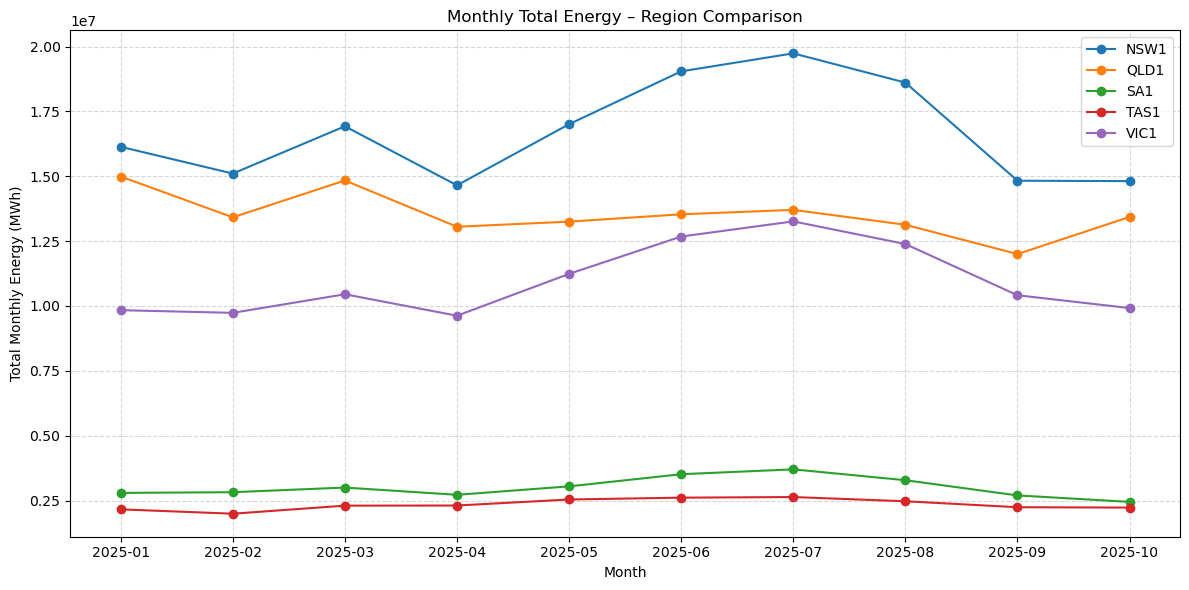

In [12]:
plt.figure(figsize=(12,6))

regions = df_monthly["region_id"].unique()

for region in regions:
    df_temp = df_monthly[df_monthly["region_id"] == region]
    plt.plot(df_temp["month"], df_temp["total_monthly_energy_mwh"], marker="o", label=region)

plt.title("Monthly Total Energy – Region Comparison")
plt.xlabel("Month")
plt.ylabel("Total Monthly Energy (MWh)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


## 🏁 Final Summary & Closing Remarks

In this notebook, we built the **monthly usage layer** for the NEM demand analytics project.

### 🔑 Key outcomes

- Aggregated **daily usage** into **monthly metrics** for each NEM region.
- Computed:
  - Average daily demand per month
  - Monthly peak and minimum demands
  - Total monthly energy (MWh)
- Visualised seasonal trends for:
  - Single regions
  - All regions combined
- Stored the final result in PostgreSQL as `monthly_usage`.

### 🎯 Why this matters

Monthly analytics provide a clear view of:

- **Seasonal demand patterns** (summer vs winter peaks)
- **Shoulder-month behaviour**
- **Regional differences** in consumption due to climate, population, and industry

This layer is essential for:

- Long-term forecasting
- Seasonal planning
- Executive summaries and Power BI dashboards
- Integrating with peak/low event analysis and region-level KPIs

With `monthly_usage` complete, we now have a robust seasonal foundation to support more advanced analytics in the next notebooks.


In [13]:
from sqlalchemy import text
with engine.connect() as conn:
    print(conn.execute(text("SELECT 1;")).fetchall())


[(1,)]


In [15]:
import pandas as pd

# Read monthly_usage table from PostgreSQL
df_monthly = pd.read_sql("""
    SELECT *
    FROM monthly_usage
    ORDER BY 1, 2;   -- order by first and second columns (e.g. date + region)
""", engine)

# Export as CSV
df_monthly.to_csv("monthly_usage.csv", index=False)

print("✅ monthly_usage.csv exported successfully!")
print("Rows exported:", len(df_monthly))


✅ monthly_usage.csv exported successfully!
Rows exported: 50
